In [1]:
# https://keras.io/examples/generative/wgan_gp/
#

import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(2)
import time
import sys
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *

from tqdm import tqdm
import matplotlib.pyplot as plt
import glob
from sklearn.utils import shuffle

from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint

# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.models import load_model
from matplotlib import pyplot


import tensorflow as tf


from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers as L
from tensorflow.keras import initializers

from skimage import io
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
from sklearn.utils import shuffle

In [2]:
foldername2class = {
	'0.0':  0,
	'0.05': 1,
	'0.1':  2,
	'0.15': 3,
	'0.2':  4,
	'0.25': 5,
	'0.3':  6,
	'0.35': 7,
	'0.4':  8,
	'0.45': 9,
	'0.5':  10,
	'0.55': 11,
	'0.6':  12,
	'0.65': 13,
	'0.7':  14,
	'0.75': 15,
	'0.8':  16,
	'0.85': 17,
	'0.9':  18,
	'0.95': 19,
	'1.0':  20,
}

In [3]:
IMG_SHAPE = (128, 128, 3)
BATCH_SIZE = 10
N_CLASSES = len(foldername2class)
# Size of the noise vector
noise_dim = 100


PATH_DATA = '../../expand_double_modes'

train_images_path = []

iterator = tqdm(glob.glob(PATH_DATA + "/*"))
for single_folder in iterator:
    img_folder = shuffle(glob.glob(single_folder + '/*'))
    for indx, single_img_path in enumerate(img_folder):
        train_images_path.append(single_img_path)
iterator.close()

train_images_path = shuffle(train_images_path)

100%|██████████| 21/21 [00:00<00:00, 122.57it/s]


In [4]:
CLASS_TO_IMGS = {}


def preprocess_images(images):
  images = (images - 127.5) / 127.5
  return images.astype('float32')

def load_dataset(path_list: list):
    iterator = tqdm(path_list)
    for single_path in iterator:
        label_s = foldername2class[single_path.split('/')[-2]]
        image = io.imread(single_path)
        image = cv2.resize(image, (IMG_SHAPE[1], IMG_SHAPE[0]))
        image_s = np.asarray(image, dtype=np.float32)[..., :3]
        if CLASS_TO_IMGS.get(str(label_s)) is None:
            CLASS_TO_IMGS[str(label_s)] = []
        CLASS_TO_IMGS[str(label_s)] += [image_s]
    iterator.close()
load_dataset(train_images_path)

100%|██████████| 37800/37800 [01:30<00:00, 417.53it/s]


In [5]:
model = tf.saved_model.load('/home/rustam/USA/beams/exp_data/gan_tests/'
                            'simple_condition_gan/results1/ep_7/models/i_2400_ep_7'
)

### Generate certain class

In [ ]:
N_GENERATE = 3_600
CLASS_GENERATE = 9

generated_images = []

iterator = tqdm(range(N_GENERATE))
for i in iterator:
    random_latent_vectors = np.random.normal(size=(1, noise_dim)).astype(np.float32)
    gen_img = model(label_i=np.array([[CLASS_GENERATE]], dtype=np.int32), noise_i=random_latent_vectors)[0]
    # scale from [-1,1] to [0,1]
    gen_img = (gen_img + 1) / 2.0
    gen_img = np.clip(gen_img * 255.0, 0, 255).astype(np.float32)
    generated_images.append(gen_img)
iterator.close()

In [ ]:
images1 = generated_images
images2 = CLASS_TO_IMGS[str(CLASS_GENERATE)][:N_GENERATE]

## Generate all images

In [7]:
N_GENERATE = 600

generated_images = []

for class_i in range(N_CLASSES):
    iterator = tqdm(range(N_GENERATE))
    for _ in iterator:
        random_latent_vectors = np.random.normal(size=(1, noise_dim)).astype(np.float32)
        gen_img = model(label_i=np.array([[class_i]], dtype=np.int32), noise_i=random_latent_vectors)[0]
        # scale from [-1,1] to [0,1]
        gen_img = (gen_img + 1) / 2.0
        gen_img = np.clip(gen_img * 255.0, 0, 255).astype(np.float32)
        generated_images.append(gen_img)
    iterator.close()

100%|██████████| 600/600 [00:05<00:00, 106.81it/s]


In [8]:
images1 = generated_images
images2 = []
for class_i in range(N_CLASSES):
    images2 += CLASS_TO_IMGS[str(class_i)][:N_GENERATE]

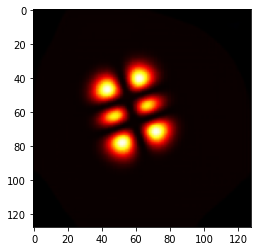

In [13]:
plt.imshow(images1[0].astype(np.uint8))

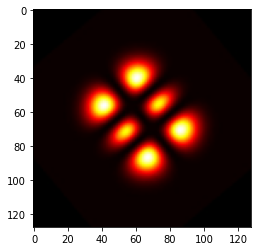

In [12]:
plt.imshow(images2[0].astype(np.uint8))

In [14]:
# example of calculating the frechet inception distance in Keras
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2, batch_calc=256):
    assert len(images1) == len(images2)
    n_batches = len(images1) // batch_calc
    images1, images2 = images1[:n_batches * batch_calc], images2[:n_batches * batch_calc]
    iterator = tqdm(range(n_batches))
    res_1 = []
    res_2 = []
    
    for i in iterator:
        i1_b, i2_b = (
            np.array(images1[i * batch_calc: (i+1)*batch_calc], dtype=np.float32), 
            np.array(images2[i * batch_calc: (i+1)*batch_calc], dtype=np.float32) 
        )
        # resize
        i1_b, i2_b = (
            scale_images(i1_b, (299,299,3)), 
            scale_images(i2_b, (299,299,3))
        )
        # pre-process
        i1_b, i2_b = (preprocess_input(i1_b), preprocess_input(i2_b))
        # calculate activations
        act1 = model.predict(i1_b)
        act2 = model.predict(i2_b)
        
        res_1.append(act1)
        res_2.append(act2)
    iterator.close()
    # calculate activations
    act1 = np.concatenate(res_1, axis=0)
    act2 = np.concatenate(res_2, axis=0)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# prepare the inception v3 model
model_incv3 = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# fid between images1 and images1
fid = calculate_fid(model_incv3, images1, images1)
print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(model_incv3, images1, images2)
print('FID (different): %.3f' % fid)

  0%|          | 0/49 [00:00<?, ?it/s]

FID (same): 0.000


100%|██████████| 49/49 [03:17<00:00,  4.03s/it]


FID (different): 47.394


# test

In [ ]:
# example of calculating the frechet inception distance in Keras
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize

# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# define two fake collections of images
images1 = randint(0, 255, 10*32*32*3)
images1 = images1.reshape((10,32,32,3))
images2 = randint(0, 255, 10*32*32*3)
images2 = images2.reshape((10,32,32,3))
print('Prepared', images1.shape, images2.shape)
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# fid between images1 and images1
fid = calculate_fid(model, images1, images1)
print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)